In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import mlflow
from mrmr import mrmr_classif
import os
import matplotlib.pyplot as plt
import preprocesamiento_datos

In [16]:
# Establecer la URI de la base de datos SQLite y configuración de MLflow
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("regresion_lineal")

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1713193978222, experiment_id='3', last_update_time=1713193978222, lifecycle_stage='active', name='regresion_lineal', tags={}>

# Selección con MRMR

Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]


 1 - Train MAE: 8363393.3741, Test MAE: 7513191.0601
1
7513191.060135548


100%|██████████| 2/2 [00:00<00:00, 63.62it/s]


 2 - Train MAE: 2960235.9527, Test MAE: 3025043.3376
2
3025043.3375628283


100%|██████████| 3/3 [00:00<00:00, 79.07it/s]


 3 - Train MAE: 2958785.0049, Test MAE: 3026768.9314
2
3025043.3375628283


100%|██████████| 4/4 [00:00<00:00, 60.85it/s]


 4 - Train MAE: 2956291.6562, Test MAE: 3027524.7721
2
3025043.3375628283


100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


 5 - Train MAE: 2954389.1959, Test MAE: 3031946.7437
2
3025043.3375628283


100%|██████████| 6/6 [00:00<00:00, 55.65it/s]


 6 - Train MAE: 2954575.0621, Test MAE: 3035559.1477
2
3025043.3375628283


100%|██████████| 7/7 [00:00<00:00, 51.62it/s]


 7 - Train MAE: 2952354.2612, Test MAE: 3043540.9918
2
3025043.3375628283


100%|██████████| 8/8 [00:00<00:00, 46.52it/s]


 8 - Train MAE: 2952099.0170, Test MAE: 3043854.5142
2
3025043.3375628283


100%|██████████| 9/9 [00:00<00:00, 51.79it/s]


 9 - Train MAE: 2951522.3529, Test MAE: 3044847.9099
2
3025043.3375628283


100%|██████████| 10/10 [00:00<00:00, 46.24it/s]


 10 - Train MAE: 2949589.8917, Test MAE: 3044611.7213
2
3025043.3375628283


100%|██████████| 11/11 [00:00<00:00, 43.81it/s]


 11 - Train MAE: 2946457.2345, Test MAE: 3060006.5438
2
3025043.3375628283


100%|██████████| 12/12 [00:00<00:00, 46.61it/s]


 12 - Train MAE: 2918505.1348, Test MAE: 3071950.7901
2
3025043.3375628283


100%|██████████| 13/13 [00:00<00:00, 45.16it/s]


 13 - Train MAE: 2918566.4863, Test MAE: 3072212.9979
2
3025043.3375628283


100%|██████████| 14/14 [00:00<00:00, 52.32it/s]


 14 - Train MAE: 2917936.3937, Test MAE: 3072960.9660
2
3025043.3375628283


100%|██████████| 15/15 [00:00<00:00, 47.30it/s]


 15 - Train MAE: 2917456.1407, Test MAE: 3073371.7005
2
3025043.3375628283


100%|██████████| 16/16 [00:00<00:00, 51.22it/s]


 16 - Train MAE: 2903034.9000, Test MAE: 3101132.7884
2
3025043.3375628283


100%|██████████| 17/17 [00:00<00:00, 48.18it/s]


 17 - Train MAE: 2896207.0904, Test MAE: 3101720.5628
2
3025043.3375628283


100%|██████████| 18/18 [00:00<00:00, 46.25it/s]


 18 - Train MAE: 2892590.0090, Test MAE: 3118690.5838
2
3025043.3375628283


100%|██████████| 19/19 [00:00<00:00, 46.96it/s]


 19 - Train MAE: 2892590.3769, Test MAE: 3122305.5850
2
3025043.3375628283


100%|██████████| 20/20 [00:00<00:00, 54.48it/s]


 20 - Train MAE: 2904706.0771, Test MAE: 3135576.5867
2
3025043.3375628283


100%|██████████| 21/21 [00:00<00:00, 55.82it/s]


 21 - Train MAE: 2904470.7473, Test MAE: 3137825.7748
2
3025043.3375628283


100%|██████████| 22/22 [00:00<00:00, 53.06it/s]


 22 - Train MAE: 2904723.3577, Test MAE: 3138178.9441
2
3025043.3375628283


100%|██████████| 23/23 [00:00<00:00, 56.18it/s]


 23 - Train MAE: 2906380.6702, Test MAE: 3136367.8609
2
3025043.3375628283


100%|██████████| 24/24 [00:00<00:00, 58.60it/s]


 24 - Train MAE: 2852311.2414, Test MAE: 3033318.2658
2
3025043.3375628283


100%|██████████| 25/25 [00:00<00:00, 53.51it/s]


 25 - Train MAE: 2851740.3919, Test MAE: 3034812.5362
2
3025043.3375628283


100%|██████████| 26/26 [00:00<00:00, 58.80it/s]


 26 - Train MAE: 2837415.3700, Test MAE: 3037409.0041
2
3025043.3375628283


100%|██████████| 27/27 [00:00<00:00, 52.45it/s]


 27 - Train MAE: 2837565.2420, Test MAE: 3034732.6647
2
3025043.3375628283


100%|██████████| 28/28 [00:00<00:00, 55.45it/s]


 28 - Train MAE: 2837387.7041, Test MAE: 3030015.9169
2
3025043.3375628283


100%|██████████| 29/29 [00:00<00:00, 43.30it/s]


 29 - Train MAE: 2849912.5944, Test MAE: 3050729.9556
2
3025043.3375628283


100%|██████████| 30/30 [00:00<00:00, 55.41it/s]


 30 - Train MAE: 2849853.5567, Test MAE: 3050813.9670
2
3025043.3375628283


100%|██████████| 31/31 [00:00<00:00, 54.96it/s]


 31 - Train MAE: 2849198.7721, Test MAE: 3053782.4875
2
3025043.3375628283


100%|██████████| 32/32 [00:00<00:00, 57.83it/s]


 32 - Train MAE: 2848457.2472, Test MAE: 3054782.4665
2
3025043.3375628283


100%|██████████| 33/33 [00:00<00:00, 57.83it/s]


 33 - Train MAE: 2850559.5203, Test MAE: 3046485.6334
2
3025043.3375628283


100%|██████████| 34/34 [00:00<00:00, 56.80it/s]


 34 - Train MAE: 2851072.7770, Test MAE: 3046019.3674
2
3025043.3375628283


100%|██████████| 35/35 [00:00<00:00, 56.28it/s]


 35 - Train MAE: 2851529.4765, Test MAE: 3046442.1646
2
3025043.3375628283


100%|██████████| 36/36 [00:00<00:00, 55.73it/s]


 36 - Train MAE: 2850737.9151, Test MAE: 3047899.8921
2
3025043.3375628283


100%|██████████| 37/37 [00:00<00:00, 57.02it/s]


 37 - Train MAE: 2846722.9801, Test MAE: 3058351.2733
2
3025043.3375628283


100%|██████████| 38/38 [00:00<00:00, 52.75it/s]


 38 - Train MAE: 2841175.9492, Test MAE: 3062193.7581
2
3025043.3375628283


100%|██████████| 39/39 [00:00<00:00, 45.79it/s]


 39 - Train MAE: 2840661.8121, Test MAE: 3062770.0181
2
3025043.3375628283


100%|██████████| 40/40 [00:00<00:00, 47.37it/s]


 40 - Train MAE: 2816791.9923, Test MAE: 3115586.1845
2
3025043.3375628283


100%|██████████| 41/41 [00:00<00:00, 46.87it/s]


 41 - Train MAE: 2816429.9859, Test MAE: 3116006.5934
2
3025043.3375628283


100%|██████████| 42/42 [00:00<00:00, 47.00it/s]


 42 - Train MAE: 2816380.6198, Test MAE: 3116208.4638
2
3025043.3375628283


100%|██████████| 43/43 [00:00<00:00, 50.56it/s]


 43 - Train MAE: 2815546.9104, Test MAE: 3121294.9601
2
3025043.3375628283


100%|██████████| 44/44 [00:00<00:00, 50.22it/s]


 44 - Train MAE: 2797156.2387, Test MAE: 3122410.0422
2
3025043.3375628283


100%|██████████| 45/45 [00:00<00:00, 58.94it/s]


 45 - Train MAE: 2787163.9657, Test MAE: 3122227.8619
2
3025043.3375628283


100%|██████████| 46/46 [00:00<00:00, 55.14it/s]


 46 - Train MAE: 2782879.8377, Test MAE: 3135194.7101
2
3025043.3375628283


100%|██████████| 47/47 [00:00<00:00, 56.36it/s]


 47 - Train MAE: 2746045.0286, Test MAE: 2922583.3605
47
2922583.3604718405


100%|██████████| 48/48 [00:00<00:00, 56.85it/s]


 48 - Train MAE: 2745708.4724, Test MAE: 2936608.9968
47
2922583.3604718405


100%|██████████| 49/49 [00:00<00:00, 58.05it/s]


 49 - Train MAE: 2743437.9161, Test MAE: 2961065.5847
47
2922583.3604718405


100%|██████████| 50/50 [00:01<00:00, 49.53it/s]


 50 - Train MAE: 2739432.6976, Test MAE: 2973671.8240
47
2922583.3604718405


100%|██████████| 51/51 [00:01<00:00, 43.01it/s]


 51 - Train MAE: 2738391.5444, Test MAE: 2970860.3919
47
2922583.3604718405


100%|██████████| 52/52 [00:00<00:00, 57.00it/s]


 52 - Train MAE: 2744577.3701, Test MAE: 2967574.0685
47
2922583.3604718405


100%|██████████| 53/53 [00:00<00:00, 55.49it/s]


 53 - Train MAE: 2770775.6344, Test MAE: 2953881.1951
47
2922583.3604718405


100%|██████████| 54/54 [00:00<00:00, 55.23it/s]


 54 - Train MAE: 2731502.2925, Test MAE: 2889183.9062
54
2889183.906231675


100%|██████████| 55/55 [00:00<00:00, 57.57it/s]


 55 - Train MAE: 2731070.5636, Test MAE: 2889170.0189
55
2889170.0188612216


100%|██████████| 56/56 [00:01<00:00, 55.03it/s]


 56 - Train MAE: 2731347.7644, Test MAE: 2889404.1091
55
2889170.0188612216


100%|██████████| 57/57 [00:01<00:00, 53.72it/s]


 57 - Train MAE: 2728489.3972, Test MAE: 2895581.6286
55
2889170.0188612216


100%|██████████| 58/58 [00:01<00:00, 51.01it/s]


 58 - Train MAE: 2743843.0884, Test MAE: 2920661.1111
55
2889170.0188612216


100%|██████████| 59/59 [00:01<00:00, 54.52it/s]


 59 - Train MAE: 2704080.1181, Test MAE: 2954648.9013
55
2889170.0188612216


100%|██████████| 60/60 [00:01<00:00, 56.50it/s]


 60 - Train MAE: 2688427.9916, Test MAE: 2993390.4191
55
2889170.0188612216


100%|██████████| 61/61 [00:01<00:00, 55.02it/s]


 61 - Train MAE: 2688395.0280, Test MAE: 3019795.2017
55
2889170.0188612216


100%|██████████| 62/62 [00:01<00:00, 58.06it/s]


 62 - Train MAE: 2689663.9498, Test MAE: 3024095.7149
55
2889170.0188612216


100%|██████████| 63/63 [00:01<00:00, 50.38it/s]


 63 - Train MAE: 2689981.3946, Test MAE: 3023209.5204
55
2889170.0188612216


100%|██████████| 64/64 [00:01<00:00, 52.01it/s]


 64 - Train MAE: 2691307.5499, Test MAE: 3024781.8095
55
2889170.0188612216


100%|██████████| 65/65 [00:01<00:00, 54.83it/s]


 65 - Train MAE: 2684678.2491, Test MAE: 3034183.1737
55
2889170.0188612216


100%|██████████| 66/66 [00:01<00:00, 53.86it/s]


 66 - Train MAE: 2684921.6539, Test MAE: 3039134.9495
55
2889170.0188612216


100%|██████████| 67/67 [00:01<00:00, 54.11it/s]


 67 - Train MAE: 2680274.6089, Test MAE: 3066043.3487
55
2889170.0188612216


100%|██████████| 68/68 [00:01<00:00, 56.50it/s]


 68 - Train MAE: 2679684.3358, Test MAE: 3066805.7266
55
2889170.0188612216


100%|██████████| 69/69 [00:01<00:00, 56.68it/s]


 69 - Train MAE: 2669035.6666, Test MAE: 3059876.0263
55
2889170.0188612216


100%|██████████| 70/70 [00:01<00:00, 56.04it/s]


 70 - Train MAE: 2655796.4987, Test MAE: 3052947.8324
55
2889170.0188612216


100%|██████████| 71/71 [00:01<00:00, 59.15it/s]


 71 - Train MAE: 2654299.9179, Test MAE: 3050474.9436
55
2889170.0188612216


100%|██████████| 72/72 [00:01<00:00, 51.46it/s]


 72 - Train MAE: 2652702.0027, Test MAE: 3049306.2325
55
2889170.0188612216


100%|██████████| 73/73 [00:01<00:00, 45.87it/s]


 73 - Train MAE: 2663154.4341, Test MAE: 3063322.1022
55
2889170.0188612216


100%|██████████| 74/74 [00:01<00:00, 57.02it/s]


 74 - Train MAE: 2664412.8431, Test MAE: 3063276.3088
55
2889170.0188612216


100%|██████████| 75/75 [00:01<00:00, 57.63it/s]


 75 - Train MAE: 2665774.3082, Test MAE: 3063250.1981
55
2889170.0188612216


100%|██████████| 76/76 [00:01<00:00, 57.88it/s]


 76 - Train MAE: 2666503.7652, Test MAE: 3068261.7046
55
2889170.0188612216


100%|██████████| 77/77 [00:01<00:00, 57.36it/s]


 77 - Train MAE: 2666257.0826, Test MAE: 3068017.8873
55
2889170.0188612216


100%|██████████| 78/78 [00:01<00:00, 58.00it/s]


 78 - Train MAE: 2668297.6773, Test MAE: 3077904.5900
55
2889170.0188612216


100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


 79 - Train MAE: 2663102.6007, Test MAE: 3109125.2859
55
2889170.0188612216


100%|██████████| 80/80 [00:01<00:00, 58.73it/s]


 80 - Train MAE: 2662832.3215, Test MAE: 3108277.9829
55
2889170.0188612216


100%|██████████| 81/81 [00:01<00:00, 57.99it/s]


 81 - Train MAE: 2662078.2978, Test MAE: 3111928.6983
55
2889170.0188612216


100%|██████████| 82/82 [00:01<00:00, 55.72it/s]


 82 - Train MAE: 2649124.5335, Test MAE: 3104934.0225
55
2889170.0188612216


100%|██████████| 83/83 [00:01<00:00, 56.52it/s]


 83 - Train MAE: 2649669.1916, Test MAE: 3102129.3267
55
2889170.0188612216


100%|██████████| 84/84 [00:01<00:00, 48.61it/s]


 84 - Train MAE: 2641519.9018, Test MAE: 3100798.8410
55
2889170.0188612216


100%|██████████| 85/85 [00:01<00:00, 57.51it/s]


 85 - Train MAE: 2642907.6542, Test MAE: 3096522.5053
55
2889170.0188612216


100%|██████████| 86/86 [00:01<00:00, 56.97it/s]


 86 - Train MAE: 2642794.4801, Test MAE: 3096382.4019
55
2889170.0188612216


100%|██████████| 87/87 [00:01<00:00, 56.99it/s]


 87 - Train MAE: 2637099.1766, Test MAE: 3059717.8775
55
2889170.0188612216


100%|██████████| 88/88 [00:01<00:00, 58.00it/s]


 88 - Train MAE: 2636524.2246, Test MAE: 3065449.4732
55
2889170.0188612216


100%|██████████| 89/89 [00:01<00:00, 55.98it/s]


 89 - Train MAE: 2628327.9571, Test MAE: 3057497.5890
55
2889170.0188612216


100%|██████████| 90/90 [00:01<00:00, 58.26it/s]


 90 - Train MAE: 2626897.5703, Test MAE: 3055065.8722
55
2889170.0188612216


100%|██████████| 91/91 [00:01<00:00, 56.34it/s]


 91 - Train MAE: 2627101.7580, Test MAE: 3053053.5162
55
2889170.0188612216


100%|██████████| 92/92 [00:01<00:00, 57.02it/s]


 92 - Train MAE: 2602990.7544, Test MAE: 3054288.9350
55
2889170.0188612216


100%|██████████| 93/93 [00:01<00:00, 52.76it/s]


 93 - Train MAE: 2600048.8470, Test MAE: 3066679.0840
55
2889170.0188612216


100%|██████████| 94/94 [00:01<00:00, 50.29it/s]


 94 - Train MAE: 2600072.4086, Test MAE: 3066705.4858
55
2889170.0188612216


100%|██████████| 95/95 [00:01<00:00, 51.30it/s]


 95 - Train MAE: 2599084.8899, Test MAE: 3074564.2923
55
2889170.0188612216


100%|██████████| 96/96 [00:01<00:00, 56.61it/s]


 96 - Train MAE: 2596369.2196, Test MAE: 3062426.3307
55
2889170.0188612216


100%|██████████| 97/97 [00:01<00:00, 56.74it/s]


 97 - Train MAE: 2590556.6881, Test MAE: 3043532.0572
55
2889170.0188612216


100%|██████████| 98/98 [00:01<00:00, 56.61it/s]


 98 - Train MAE: 2592734.8587, Test MAE: 3052495.9654
55
2889170.0188612216


100%|██████████| 99/99 [00:01<00:00, 57.40it/s]


 99 - Train MAE: 2592600.3385, Test MAE: 3054268.6890
55
2889170.0188612216


100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


 100 - Train MAE: 2596599.6113, Test MAE: 3063163.2655
55
2889170.0188612216


100%|██████████| 101/101 [00:01<00:00, 54.34it/s]


 101 - Train MAE: 2597893.3297, Test MAE: 3058783.7949
55
2889170.0188612216


100%|██████████| 102/102 [00:01<00:00, 53.53it/s]


 102 - Train MAE: 2596087.0215, Test MAE: 3061935.4211
55
2889170.0188612216


100%|██████████| 103/103 [00:01<00:00, 56.64it/s]


 103 - Train MAE: 2596733.0711, Test MAE: 3062176.9535
55
2889170.0188612216


100%|██████████| 104/104 [00:01<00:00, 55.71it/s]


 104 - Train MAE: 2595963.6166, Test MAE: 3071025.9249
55
2889170.0188612216


100%|██████████| 105/105 [00:01<00:00, 56.51it/s]


 105 - Train MAE: 2596374.0595, Test MAE: 3072025.5318
55
2889170.0188612216


100%|██████████| 106/106 [00:01<00:00, 56.36it/s]


 106 - Train MAE: 2598734.9544, Test MAE: 3079098.3923
55
2889170.0188612216


100%|██████████| 107/107 [00:01<00:00, 56.20it/s]


 107 - Train MAE: 2597874.1881, Test MAE: 3076788.1664
55
2889170.0188612216


100%|██████████| 108/108 [00:01<00:00, 56.18it/s]


 108 - Train MAE: 2601868.6034, Test MAE: 3078461.1493
55
2889170.0188612216


100%|██████████| 109/109 [00:02<00:00, 54.46it/s]


 109 - Train MAE: 2603452.0635, Test MAE: 3075450.9012
55
2889170.0188612216


100%|██████████| 110/110 [00:01<00:00, 56.44it/s]


 110 - Train MAE: 2602595.7871, Test MAE: 3085180.0168
55
2889170.0188612216


100%|██████████| 111/111 [00:02<00:00, 54.86it/s]


 111 - Train MAE: 2600370.3394, Test MAE: 3094397.8714
55
2889170.0188612216


100%|██████████| 112/112 [00:02<00:00, 55.78it/s]


 112 - Train MAE: 2599118.0431, Test MAE: 3072940.8738
55
2889170.0188612216


100%|██████████| 113/113 [00:02<00:00, 56.03it/s]


 113 - Train MAE: 2598806.0494, Test MAE: 3078590.0624
55
2889170.0188612216


100%|██████████| 114/114 [00:02<00:00, 56.77it/s]


 114 - Train MAE: 2593406.1863, Test MAE: 3089952.6662
55
2889170.0188612216


100%|██████████| 115/115 [00:02<00:00, 53.64it/s]


 115 - Train MAE: 2599320.3136, Test MAE: 3105936.8531
55
2889170.0188612216


100%|██████████| 116/116 [00:02<00:00, 52.89it/s]


 116 - Train MAE: 2599208.0626, Test MAE: 3105893.2905
55
2889170.0188612216


100%|██████████| 117/117 [00:02<00:00, 53.66it/s]


 117 - Train MAE: 2599208.0626, Test MAE: 3108795.0195
55
2889170.0188612216


100%|██████████| 118/118 [00:02<00:00, 56.97it/s]


 118 - Train MAE: 2599208.0626, Test MAE: 3110423.7381
55
2889170.0188612216


100%|██████████| 119/119 [00:02<00:00, 56.83it/s]


 119 - Train MAE: 2598796.9778, Test MAE: 3105077.4205
55
2889170.0188612216


100%|██████████| 120/120 [00:02<00:00, 56.04it/s]


 120 - Train MAE: 2597415.9438, Test MAE: 3101647.6835
55
2889170.0188612216


100%|██████████| 121/121 [00:02<00:00, 57.03it/s]


 121 - Train MAE: 2597587.9613, Test MAE: 3103274.7468
55
2889170.0188612216


100%|██████████| 122/122 [00:02<00:00, 57.29it/s]


 122 - Train MAE: 2600033.1220, Test MAE: 3092330.5092
55
2889170.0188612216


100%|██████████| 123/123 [00:02<00:00, 51.62it/s]


 123 - Train MAE: 2601419.0859, Test MAE: 3113531.8661
55
2889170.0188612216


100%|██████████| 124/124 [00:02<00:00, 42.81it/s]


 124 - Train MAE: 2604558.3817, Test MAE: 3120380.2858
55
2889170.0188612216


100%|██████████| 125/125 [00:02<00:00, 41.91it/s]


 125 - Train MAE: 2607807.9404, Test MAE: 3119690.3042
55
2889170.0188612216


100%|██████████| 126/126 [00:04<00:00, 29.23it/s]


 126 - Train MAE: 2607826.7775, Test MAE: 3119702.2535
55
2889170.0188612216


100%|██████████| 127/127 [00:04<00:00, 29.89it/s]


 127 - Train MAE: 2607917.3220, Test MAE: 3119837.7624
55
2889170.0188612216


100%|██████████| 128/128 [00:04<00:00, 26.83it/s]


 128 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 26.53it/s]


 129 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 26.77it/s]


 130 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.38it/s]


 131 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.53it/s]


 132 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 28.26it/s]


 133 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 28.01it/s]


 134 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:05<00:00, 23.56it/s]


 135 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.26it/s]


 136 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 26.76it/s]


 137 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:05<00:00, 25.60it/s]


 138 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 25.88it/s]


 139 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.32it/s]


 140 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.19it/s]


 141 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.13it/s]


 142 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.68it/s]


 143 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.26it/s]


 144 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.99it/s]


 145 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.65it/s]


 146 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.85it/s]


 147 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


100%|██████████| 129/129 [00:04<00:00, 27.32it/s]


 148 - Train MAE: 2609003.3496, Test MAE: 3114038.4914
55
2889170.0188612216


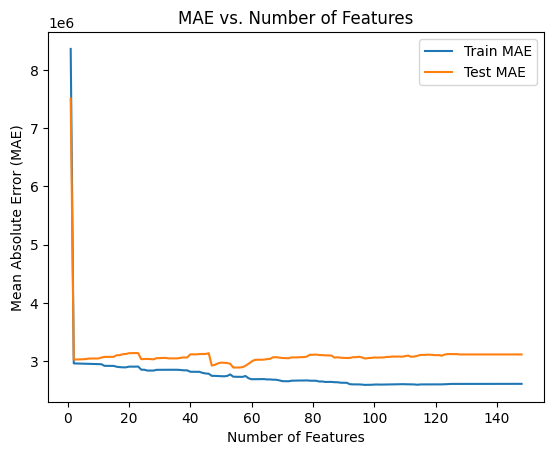

In [12]:
# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="MRMR Feature Selection"):
    import numpy as np
    # Obtener los datos preprocesados
    X_train, X_val, X_test, y_train, y_val, y_test, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,[], False)
    
    # Definir la función para calcular el MRMR
    def calculate_mrmr_features(X, y, K):
        selected_features = mrmr_classif(X=X, y=y, K=K)
        return selected_features
    
    # Definir el rango de características que deseamos considerar
    feature_range = range(1, len(X_train.columns) + 1)
    
    # Listas para almacenar las métricas
    train_maes = []
    test_maes = []
    num_features_list = []
    
    # Variables para almacenar las 17 características y su MAE correspondiente
    selected_features_17 = None
    mae_17 = None
    
    # Iterar sobre todas las combinaciones de características
    for num_features in feature_range:
        # Calcular las características seleccionadas usando MRMR
        selected_features = calculate_mrmr_features(X_train, y_train, num_features)
        
        # Seleccionar las columnas correspondientes en X_train y X_test
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Entrenar el modelo de regresión lineal
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
    
        # Realizar predicciones en el conjunto de entrenamiento y de prueba
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
        
        # Calcular el error absoluto medio (MAE) para evaluar el modelo en ambos conjuntos
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Almacenar las métricas y el número de características
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        num_features_list.append(num_features)
        
        # Imprimir el MAE en cada iteración
        print(f" {num_features} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        
        # Registrar el MAE en MLflow
        mlflow.log_metric(f"train_mae_{num_features}", train_mae)
        mlflow.log_metric(f"test_mae_{num_features}", test_mae)
        print(feature_range[np.argmin(test_maes)])
        print(min(test_maes))
    # Graficar los resultados
    plt.plot(num_features_list, train_maes, label='Train MAE')
    plt.plot(num_features_list, test_maes, label='Test MAE')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs. Number of Features')
    plt.legend()
    plt.show()

Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet
Selected features with 9 features: ['Mins' 'AvgP' 'Titularidades' 'Equipo_pos' '1_año_anterior'
 '2_año_anterior' '3_año_anterior' '4_año_anterior' '5_año_anterior']
Selected features with 12 features: ['Mins' 'Assists' 'MotM' 'AvgP' 'Titularidades' 'Equipo_pos'
 '1_año_anterior' '2_año_anterior' '3_año_anterior' '4_año_anterior'
 '5_año_anterior' 'Equipo_Real Madrid']
Selected features with 17 features: ['Mins' 'Goals' 'Assists' 'SpG' 'MotM' 'KeyP' 'OffDrb' 'AvgP'
 'Titularidades' 'Equipo_pos' '1_año_anterior' '2_año_anterior'
 '3_año_anterior' '4_año_anterior' '5_año_anterior' 'Equipo_FC Barcelona'
 'Equipo_Real Madrid']
Selected features with 20 features: ['Mins' 'Goals' 'Assists' 'SpG' 'PS%' 'MotM' 'KeyP' 'OffDrb' 'AvgP' 'ThrB'
 'Titularidades' 'Equipo_pos' '1_año_anterior' '2_año_anterior'
 '3_año_anterior' '4_año_anterior' '5_año_anterior' 'Equipo_FC Bar

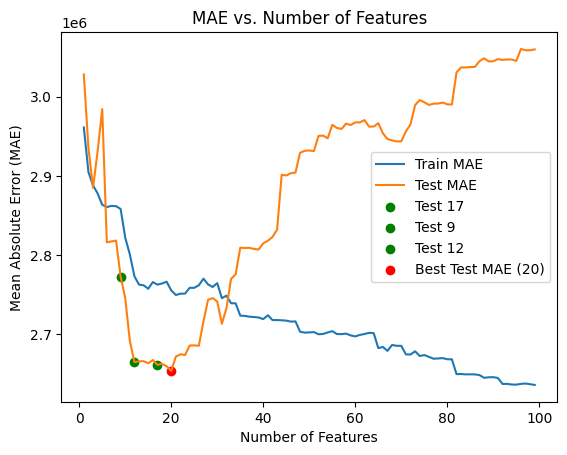

<Figure size 640x480 with 0 Axes>

In [18]:
import mlflow
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="KBest Feature Selection"):

    # Obtener los datos preprocesados
    X_train, X_val, X_test, y_train, y_val, y_test, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,[], False)
    
    # Definir el rango de características que deseamos considerar
    feature_range = range(1, 100)
    
    # Listas para almacenar las métricas
    train_maes = []
    test_maes = []
    
    # Iterar sobre todas las combinaciones de características
    for num_features in feature_range:
        # Seleccionar las mejores k características
        selector = SelectKBest(score_func=f_regression, k=num_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        # Entrenar un modelo de regresión lineal con las características seleccionadas
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
    
        # Realizar predicciones en el conjunto de prueba
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
        
        # Calcular el error absoluto medio (MAE) para evaluar el modelo en ambos conjuntos
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Almacenar las métricas
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        
        # Registrar los MAE en MLflow para cada iteración
        mlflow.log_metric(f"train_mae_{num_features}", train_mae)
        mlflow.log_metric(f"test_mae_{num_features}", test_mae)
        
        # Verificar si se han encontrado las 9 características
        if num_features == 9:
            # Obtener las características seleccionadas
            selected_features_9 = np.array(X_train.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_9)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_9", selected_features_9)
        
        if num_features == 12:
            # Obtener las características seleccionadas
            selected_features_12 = np.array(X_train.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_12)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_12", selected_features_12)
        # Verificar si se han encontrado las 17 características
        if num_features == 17:
            # Obtener las características seleccionadas
            selected_features_17 = np.array(X_train.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_17)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_17", selected_features_17)
            
        if num_features == 20:
            # Obtener las características seleccionadas
            selected_features_20 = np.array(X_train.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_20)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_20", selected_features_20)
    
    # Encontrar el número de características que produce el menor error absoluto medio en el conjunto de prueba
    best_num_features = feature_range[np.argmin(test_maes)]
    print("Best number of features:", best_num_features)
    
    # Graficar los resultados
    plt.plot(feature_range, train_maes, label='Train MAE')
    plt.plot(feature_range, test_maes, label='Test MAE')
    plt.scatter(17, test_maes[16], color='green', label='Test 17')
    plt.scatter(9, test_maes[8], color='green', label='Test 9')
    plt.scatter(12, test_maes[11], color='green', label='Test 12')
    plt.scatter(best_num_features, min(test_maes), color='red', label='Best Test MAE (20)')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs. Number of Features')
    plt.legend()
    plt.show()
    image_path = "grafica_selección_variables.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, artifact_path="grafica seleccion variables")

# Separado en posiciones

In [19]:
from sklearn.feature_selection import f_regression, SelectKBest
X_train, X_val, X_test, y_train, y_val, y_test, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,[], False)

defensas_cols = [
    'position_Centre-Back', 'position_Left-Back', 'position_Right-Back'
]
porteros_cols = ['position_Goalkeeper']
medio_cols = [
    'position_Attacking Midfield', 'position_Central Midfield', 'position_Defensive Midfield', 
    'position_Left Midfield', 'position_Centre-Forward'
]
delanteros_cols = [
    'position_Centre-Forward', 'position_Second Striker', 'position_Right Winger','position_Left Winger'
]

def filtrar_posiciones(X, y, posiciones):
    # Filtra las filas donde alguna de las posiciones es 1
    mask = X[posiciones].sum(axis=1) > 0
    return X[mask], y[mask]

# Filtrar y dividir para defensas
X_train_defensas, y_train_defensas = filtrar_posiciones(X_train, y_train, defensas_cols)
X_val_defensas, y_val_defensas = filtrar_posiciones(X_val, y_val, defensas_cols)
X_test_defensas, y_test_defensas = filtrar_posiciones(X_test, y_test, defensas_cols)

# Filtrar y dividir para porteros
X_train_porteros, y_train_porteros = filtrar_posiciones(X_train, y_train, porteros_cols)
X_val_porteros, y_val_porteros = filtrar_posiciones(X_val, y_val, porteros_cols)
X_test_porteros, y_test_porteros = filtrar_posiciones(X_test, y_test, porteros_cols)

# Filtrar y dividir para mediocampistas
X_train_medio, y_train_medio = filtrar_posiciones(X_train, y_train, medio_cols)
X_val_medio, y_val_medio = filtrar_posiciones(X_val, y_val, medio_cols)
X_test_medio, y_test_medio = filtrar_posiciones(X_test, y_test, medio_cols)

# Filtrar y dividir para delanteros
X_train_delanteros, y_train_delanteros = filtrar_posiciones(X_train, y_train, delanteros_cols)
X_val_delanteros, y_val_delanteros = filtrar_posiciones(X_val, y_val, delanteros_cols)
X_test_delanteros, y_test_delanteros = filtrar_posiciones(X_test, y_test, delanteros_cols)


import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def entrenar_evaluar_modelo_regresion_kbest(X_train, y_train, X_val, y_val, X_test, y_test, position_name, k_range):
    best_k = 0
    best_mae_val = float('inf')
    best_mae_test = float('inf')
    best_model = None
    
    with mlflow.start_run(run_name=position_name):
        for k in k_range:
            # Selección de características
            selector = SelectKBest(score_func=f_regression, k=k)
            X_train_kbest = selector.fit_transform(X_train, y_train)
            X_val_kbest = selector.transform(X_val)
            X_test_kbest = selector.transform(X_test)

            # Entrenar modelo
            modelo = LinearRegression()
            modelo.fit(X_train_kbest, y_train)

            # Predecir en conjunto de validación
            predicciones_val = modelo.predict(X_val_kbest)
            predicciones_test = modelo.predict(X_test_kbest)

            # Calcular error absoluto medio en conjunto de validación
            mae_val = mean_absolute_error(y_val, predicciones_val)

            # Actualizar mejor modelo si se encuentra un nuevo mínimo MAE en validación
            if mae_val < best_mae_val:
                best_mae_val = mae_val
                best_mae_test = mean_absolute_error(y_test, predicciones_test)
                best_k = k
                best_model = modelo

        # Registrar métricas y modelo en MLflow
        mlflow.log_param("best_k", best_k)
        mlflow.log_metric("best_mean_absolute_error_validation", best_mae_val)
        mlflow.log_metric("best_mean_absolute_error_test", best_mae_test)
        mlflow.sklearn.log_model(best_model, "best_model")
        
        print(f"{position_name}: Mejor k = {best_k}, Mean Absolute Error en validación:", best_mae_val)
        print(f"{position_name}: Mean Absolute Error en prueba:", best_mae_test)

        
# Rango de k para la selección de características
k_range = range(1, 31)

# Entrenar y evaluar modelo de defensas con k mejores características
entrenar_evaluar_modelo_regresion_kbest(X_train_defensas, y_train_defensas, X_val_defensas, y_val_defensas, X_test_defensas, y_test_defensas, "defensas", k_range)

# Entrenar y evaluar modelo de porteros con k mejores características
entrenar_evaluar_modelo_regresion_kbest(X_train_porteros, y_train_porteros, X_val_porteros, y_val_porteros, X_test_porteros, y_test_porteros, "porteros", k_range)

# Entrenar y evaluar modelo de mediocampistas con k mejores características
entrenar_evaluar_modelo_regresion_kbest(X_train_medio, y_train_medio, X_val_medio, y_val_medio, X_test_medio, y_test_medio, "mediocampistas", k_range)

# Entrenar y evaluar modelo de delanteros con k mejores características
entrenar_evaluar_modelo_regresion_kbest(X_train_delanteros, y_train_delanteros, X_val_delanteros, y_val_delanteros, X_test_delanteros, y_test_delanteros, "delanteros", k_range)

Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet
defensas: Mejor k = 2, Mean Absolute Error en validación: 2329616.9548635134
defensas: Mean Absolute Error en prueba: 2387188.352701865
porteros: Mejor k = 1, Mean Absolute Error en validación: 2995563.342763367
porteros: Mean Absolute Error en prueba: 1911311.0835787451
mediocampistas: Mejor k = 4, Mean Absolute Error en validación: 3003232.008301105
mediocampistas: Mean Absolute Error en prueba: 3127964.94996276
delanteros: Mejor k = 5, Mean Absolute Error en validación: 2879996.438919664
delanteros: Mean Absolute Error en prueba: 2965614.5357839367


# Completo por posiciones

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import mlflow
import preprocesamiento_datos
import pandas as pd
import numpy as np

X_train_completo, X_val_completo, X_test_completo, y_train_completo, y_val_completo, y_test_completo, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,[], False)
# Obtener los datos preprocesados
X_train, X_val, X_test, y_train, y_val, y_test, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,['Mins', 'Goals', 'Assists', 'SpG', 'PS%', 'MotM', 'KeyP', 'OffDrb', 'AvgP', 'ThrB','Titularidades', 'Equipo_pos', '1_año_anterior', '2_año_anterior', '3_año_anterior', '4_año_anterior', '5_año_anterior', 'Equipo_FC Barcelona', 'Equipo_Real Madrid', 'nationality_Germany'], True)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_val_pred = model.predict(X_val)

# Calcular el error absoluto medio en el conjunto de validación
val_mae = mean_absolute_error(y_val, y_val_pred)

# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="COMPLETO EN POSICIONES"):
    # Registrar el error absoluto medio en el conjunto de validación en MLflow
    mlflow.log_metric("val_mae", val_mae)

    # Entrenar el modelo final con todos los datos de entrenamiento y validación
    X_train_final = np.concatenate((X_train, X_val))
    y_train_final = np.concatenate((y_train, y_val))
    model.fit(X_train_final, y_train_final)

    # Realizar predicciones en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    
    # Calcular el error absoluto medio en el conjunto de prueba
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Registrar el error absoluto medio en el conjunto de prueba en MLflow
    mlflow.log_metric("test_mae", test_mae)
    print("Test MAE:", test_mae)
    
    # Calcular medias por grupos de posiciones
    li = []
    posiciones = ['Left-Back', 'Centre-Back', 'Defensive Midfield',
       'Centre-Forward','Second Striker','Right Winger', 'Left Winger','Central Midfield', 
       'Attacking Midfield', 'Right-Back',
       'Left Midfield', 'Goalkeeper']
    
    # Crear DataFrame para comparar predicciones vs. valores reales
    pred_vs_real = pd.DataFrame({'y_test': y_test, 'y_pred_rf': y_test_pred, 'dif': abs(y_test-y_test_pred)})
    
    for p in posiciones:
        # Filtrar datos por posición
        solo_posicion = pred_vs_real[X_test_completo['position_' + p] == 1]
        # Calcular el error medio absoluto para esta posición
        mean_dif = np.mean(solo_posicion['dif'])
        li.append(mean_dif)
    
    # Calcular medias de errores para cada posición
    mean_defenders = np.mean(li[0:3])
    mean_strikers = np.mean(li[3:7])
    mean_goalkeepers = li[11]
    mean_midfielders = 4 * test_mae - (mean_defenders + mean_strikers + mean_goalkeepers)
    
    print('Defensas:', mean_defenders)
    print('Delanteros:', mean_strikers)
    print('Mediocampistas:', mean_midfielders)
    print('Porteros:', mean_goalkeepers)
    
    # Guardar las métricas específicas en MLflow
    mlflow.log_metric("mean_error_defenders", mean_defenders)
    mlflow.log_metric("mean_error_strikers", mean_strikers)
    mlflow.log_metric("mean_error_midfielders", mean_midfielders)
    mlflow.log_metric("mean_error_goalkeepers", mean_goalkeepers)

Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet
Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet
['Mins', 'Goals', 'Assists', 'SpG', 'PS%', 'MotM', 'KeyP', 'OffDrb', 'AvgP', 'ThrB', 'Titularidades', 'Equipo_pos', '1_año_anterior', '2_año_anterior', '3_año_anterior', '4_año_anterior', '5_año_anterior', 'Equipo_FC Barcelona', 'Equipo_Real Madrid', 'nationality_Germany']
Test MAE: 2564070.2922655987
Defensas: 2263098.1744297557
Delanteros: 2376611.7409486934
Mediocampistas: 3369311.471848605
Porteros: 2247259.7818353404


# COMPLETO POR PRECIO

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import mlflow
import preprocesamiento_datos
import pandas as pd
import numpy as np

# Obtener los datos preprocesados
X_train, X_val, X_test, y_train, y_val, y_test, RANDOM_STATE = preprocesamiento_datos.preprocesamiento(False,['Mins', 'Goals', 'Assists', 'SpG', 'MotM', 'KeyP', 'OffDrb', 'AvgP', 'Titularidades', 'Equipo_pos', '1_año_anterior', '2_año_anterior', '3_año_anterior', '4_año_anterior', '5_año_anterior', 'Equipo_FC Barcelona', 'Equipo_Real Madrid'], True)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_val_pred = model.predict(X_val)

# Calcular el error absoluto medio en el conjunto de validación
val_mae = mean_absolute_error(y_val, y_val_pred)

# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="COMPLETO POR PRECIO"):
    # Registrar el error absoluto medio en el conjunto de validación en MLflow
    mlflow.log_metric("val_mae", val_mae)

    # Entrenar el modelo final con todos los datos de entrenamiento y validación
    X_train_final = np.concatenate((X_train, X_val))
    y_train_final = np.concatenate((y_train, y_val))
    model.fit(X_train_final, y_train_final)

    # Realizar predicciones en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    
    # Calcular el error absoluto medio en el conjunto de prueba
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Registrar el error absoluto medio en el conjunto de prueba en MLflow
    mlflow.log_metric("test_mae", test_mae)
    print("Test MAE:", test_mae)
    
    # Crear DataFrame para comparar predicciones vs. valores reales
    pred_vs_real = pd.DataFrame({'y_test': y_test, 'y_pred_rf': abs(y_test_pred), 'dif': abs(y_test-abs(y_test_pred))})
    
    # Definir los rangos de precios
    rangos_precios = [(0, 1000000), (1000000, 5000000), (5000000, 10000000), (10000000, 20000000), (20000000, 40000000), (40000000, 80000000)]

    # Calcular el error medio absoluto para cada rango de precios
    error_rango = []
    for rango in rangos_precios:
        # Seleccionar las filas donde y_test entra dentro de cada intervalo
        pred_vs_real_rango = pred_vs_real[(pred_vs_real['y_test'] >= rango[0]) & (pred_vs_real['y_test'] < rango[1])]
        # Calcular la media de las diferencias para el intervalo actual
        mean_dif = pred_vs_real_rango['dif'].mean()
        error_rango.append(mean_dif)
        # Imprimir y registrar el error medio absoluto para el intervalo actual
        print(f'Rango de precios {rango[0]/1000000}M-{rango[1]/1000000}M: {mean_dif}')
        mlflow.log_metric(f"error_rango_{rango[0]/1000000}M_{rango[1]/1000000}M", mean_dif)


Archivo Datos_la_liga_preparados_entrenamiento.parquet guardado en: ../Downloads\Datos_la_liga_preparados_entrenamiento.parquet
['Mins', 'Goals', 'Assists', 'SpG', 'MotM', 'KeyP', 'OffDrb', 'AvgP', 'Titularidades', 'Equipo_pos', '1_año_anterior', '2_año_anterior', '3_año_anterior', '4_año_anterior', '5_año_anterior', 'Equipo_FC Barcelona', 'Equipo_Real Madrid']
Test MAE: 2565384.4021002166
Rango de precios 0.0M-1.0M: 752134.419875454
Rango de precios 1.0M-5.0M: 1173293.526770147
Rango de precios 5.0M-10.0M: 2141189.5850945795
Rango de precios 10.0M-20.0M: 3258661.693341575
Rango de precios 20.0M-40.0M: 6934176.4262952935
Rango de precios 40.0M-80.0M: 16864778.969188973
